<a href="https://colab.research.google.com/github/mett29/DL-Competition/blob/master/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation challenge for ANNDL 2019-2020

Made by :

LEADERBOARD NICKNAME : 10527332_10527346

NAME_1: Mattia

LAST-NAME_1: Mancassola

STUDENT-ID_1:10527332

NAME_2: Daniele

LAST-NAME_2: Parravicini

STUDENT-ID_2 :10527346

We used Colab and Kaggle to train and evaluate our models

We kept a validation dataset percentage sometimes at 20% and sometimes at 10%, depending on the particular model under consideration. More details about dataset split used for the last models are contained in the notebook.

## Workflow:

We started by implementing the U-Net model as described in the paper. Then, we adjusted the model by adding some layers like: 

- BatchNormalization() to decrease the variance and mean of the feature maps.
- Dropout(), even if batch normalization should in theory make unnecessary the presence of other regularization techniques.
- Conv2DTranspose() instead of UpSampling2D(), in order to use transpose convolution. Following some practical advices found in other Kaggle challenges we then substitute this layer with an UpSampling2D() followed by a Conv2D(), which indeed seemed to give a small improvement.

We tried also different models, like **DenseUNet** and **ResUNet** (described later), but U-Net turned out to be the best one.

Once found a good model, with which we reached 0.69 validation IoU, we focused on the **preprocessing** part, in order to give more meaningful and exploitable information to the model. Here is the list of what we tried:

- Data augmentation: even simple data augmentation like horizontal/vertical flip, rotation or shift did not seem to improve the model, with the drawback of increasing a lot the training time.
- Following this [paper](https://pdfs.semanticscholar.org/4d37/ddb41c799e67ed2d2a5f16fe2156dbec8959.pdf) we considered only the red channels, reaching about 0.66 val_IoU.
- We used histogram equalization and local equalization on the input images --> negligible improvements
- We used different filters using the Skimage library in order to reduce noise and enhance constrast, like Gaussian filter. None of these worked.
- We extracted a sort of feature from the input image and then we provided it as an additional channel of the input images (ImageFilter.FIND_EDGES).
- We tried a custom data augmentation, aimed at enriching the dataset by creating synthetic aerial images. The idea was that to extract buildings from the original dataset and past them in random positions of the new input images. The problem was that the training time grew up exponentially, making the process unfeasible.

Essentially, after all these attempts, the best model was still the 0.69 val_IoU. We then decided to do some **postprocessing**, in order to make our predictions more precise and smoother. We tried as follows:

- We used some Morphological Transformations provided by OpenCV, like closing and opening. Closing led to a small improvement on the test set.
- We used OpenCV to create and smooth polygons from pixels, polygonizing the buildings in the masks. Even with a low epsilon, i.e. by taking many pixels to interpolate, the results were a bit worse.

Something which instead led to a relatively big improvement was the use of a combination of loss functions. More precisely, we used both the **binary_crossentropy()** and the **dice_loss()**. The latter was weighted (multiplied by 5.0) to deal with the unbalance of the masks.
Speaking of weights, we also tried to add two weights to the binary_crossentropy(), more precisely:

- weight more errors in the nearby of the buildings to foster the optimizer towards better contours.
- weight more small buildings to prevent the optimizer to ignore them.

Both the proposed solutions did not lead to improvements. 

*More on all the experiments we tried can be found in the final section of the notebook.*

Finally, at the end we skipped to **transfer learning**. At the beginning we used VGG16, since it was the simplest model to implement with skip connections. However, it did not give good results. Thus, we used other pretrained encoders, like ResNet34/50 and some others. In order to avoid the implementation of the different models with skip connections, we used the [segmentation_models](https://github.com/qubvel/segmentation_models) library to prototype and test much more easily. By using efficientnetb0 as backbone of the standard U-Net, we ended up with a 0.64797 on the test set, which is our best score.

**NOTE:** *in order to use such library we had to downgrade tensorflow to a version below 2.0.*

In [ ]:
# This permits to load the dataset on colab.
# We chose to take advantage of github to rapidly load all the data on colab.

from getpass import getpass
import os

user = getpass('Github user')
password = getpass('Github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!git clone https://$GITHUB_AUTH@github.com/DanieleParravicini/DL-CompetitionsDatasets
os.environ['GITHUB_AUTH'] = ''

# Of course it is not mandatory to load the dataset from a remote repo.
# You can simply unpack the kaggle competition zip in a local directory named 'DL-CompetitionsDatasets'

Github user··········
Github password··········
Cloning into 'DL-CompetitionsDatasets'...
remote: Enumerating objects: 18606, done.
remote: Total 18606 (delta 0), reused 0 (delta 0), pack-reused 18606
Receiving objects: 100% (18606/18606), 1.37 GiB | 37.51 MiB/s, done.
Resolving deltas: 100% (7114/7114), done.
Checking out files: 100% (18582/18582), done.


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from PIL import Image
from PIL import ImageFilter
from PIL import ImageEnhance 
from PIL import ImageOps  

import cv2
from scipy import ndimage
from datetime import datetime
import time
import os
import numpy as np
import matplotlib.pyplot as plt

2.0.0


# Loading datasets

In [2]:
SEED = 2019
tf.random.set_seed(SEED)
#tf.set_random_seed(SEED) # Tensorflow 1.x

In [3]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
PATH = ''
on_kaggle = False
if on_kaggle: 
    PATH = "/kaggle/input/ann-and-dl-image-segmentation/Segmentation_Dataset"
else:
    PATH = 'DL-CompetitionsDatasets/Segmentation_Dataset'

batch_size = 32

In [ ]:
apply_data_augmentation = False

# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(rotation_range=10,
                                        zoom_range=[0.5,1],
                                        horizontal_flip=True,
                                        vertical_flip=True,  
                                        fill_mode='nearest',                           
                                        rescale=1./255,
                                        validation_split=0.2)
    train_mask_data_gen = ImageDataGenerator(rotation_range=10,
                                        zoom_range=[0.5,1],
                                        horizontal_flip=True,
                                        vertical_flip=True,  
                                        fill_mode='nearest',                           
                                        rescale=1./255,
                                        validation_split=0.2) 
else:
    train_img_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_mask_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
dataset_dir = os.path.join(PATH, 'training')

train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(dataset_dir, 'images'),
                                               batch_size=batch_size,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=True,
                                               subset='training',
                                               #interpolation='bilinear',
                                               seed=SEED)

train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(dataset_dir, 'masks'),
                                               batch_size=batch_size,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=True,
                                               subset='training',
                                               #interpolation='bilinear',
                                               color_mode='grayscale',
                                               seed=SEED)

train_gen = zip(train_img_gen, train_mask_gen)

# Validation
valid_img_gen = train_img_data_gen.flow_from_directory(os.path.join(dataset_dir, 'images'),
                                               batch_size=batch_size, 
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=False,
                                               subset='validation',
                                               #interpolation='bilinear',
                                               seed=SEED)

valid_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(dataset_dir, 'masks'),
                                               batch_size=batch_size, 
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=False,
                                               subset='validation',
                                               #interpolation='bilinear',
                                               color_mode='grayscale',
                                               seed=SEED)

valid_gen = zip(valid_img_gen, valid_mask_gen)

Found 6118 images belonging to 1 classes.
Found 6118 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 4, figsize=(15, 15))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

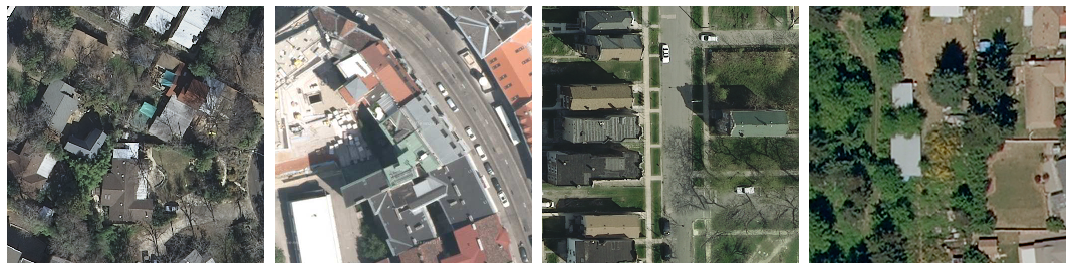

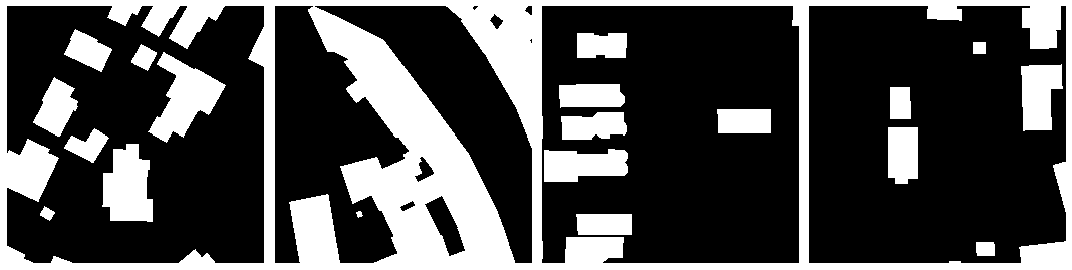

In [ ]:
def grayscale_to_colour(gray_img):
    black = [0, 0, 0] # Background
    white = [255, 255, 255] # Buildings

    colour_img = np.zeros([gray_img.shape[0], gray_img.shape[1], 3])
    return np.where(gray_img == 1, white, black )


sample_training_images, sample_training_masks = next(train_gen)
plotImages(sample_training_images[:4])
sample_training_masks_imaged = list(map( grayscale_to_colour ,sample_training_masks[:4]))
plotImages(sample_training_masks_imaged)

In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, 3], [None, IMG_HEIGHT, IMG_WIDTH, 1]))

'''When using data augmentation on masks it's a good idea to cast mask tensor to tf.int32. 
When applying geometric transformations, like rotation or zoom, the output is interpolated so you will end up with values in [0, 1] 
which are no longer binary. Casting to integer will allow to obtain again binary masks.'''

def prepare_target(x_, y_):
    y2_ = tf.cast(tf.cast(y_, tf.int32), tf.float32)
    return x_, y2_

train_dataset = train_dataset.map(prepare_target)
train_dataset = train_dataset.repeat()
train_dataset_cached = train_dataset.cache()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, 3], [None, IMG_HEIGHT, IMG_WIDTH, 1]))

valid_dataset = valid_dataset.map(prepare_target)
valid_dataset = valid_dataset.repeat()
valid_dataset_cached = valid_dataset.cache()

# Model

In [4]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu", kernel_initializer='he_normal')(x)
    c = tf.keras.layers.Dropout(0.2)(c)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu", kernel_initializer='he_normal')(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    p = tf.keras.layers.BatchNormalization()(p)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(us)
    concat = tf.keras.layers.Concatenate()([c, skip])
    c = tf.keras.layers.Dropout(0.2)(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(c)
    c = tf.keras.layers.Dropout(0.2)(c)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(c)
    p = tf.keras.layers.BatchNormalization()(c)
    return p

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(x)
    c = tf.keras.layers.Dropout(0.2)(c)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(c)
    p = tf.keras.layers.BatchNormalization()(c)
    return p

In [5]:
def UNet():
    # Instead of a single model this snippet returns an array of them.
    # All of them share the convolution part of the network and part of the upsampling. 
    # This allows to train the whole network in different steps, by consider different levels of upsampling,
    # as done in the paper 'Fully Convolutional Networks for Semantic Segmentation'. 
    # More info about this in the last part of the notebook. 
    
    models = []
    
    f = [32, 32, 64, 128, 256]
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 3))
    p0 = inputs
    
    downsampling_layers  = [p0]
    convolutional_layers = []
    # create a downsampling part of the network
    # and save the convolutions to enable creation of skip connection
    for i, n_filt in enumerate(f[:-1]):
        cx, px = down_block(downsampling_layers[i], n_filt) # spatial extent 2A x 2A -> A x A
        downsampling_layers.append(px)
        convolutional_layers.append(cx)
    
    bn = bottleneck(downsampling_layers[-1], f[-1])
    
    # create the upsampling part of the network
    upsampling_layers = [bn]
    for i, n_filt in enumerate(reversed(f[:-1]) ):
        ux = up_block(upsampling_layers[i], convolutional_layers[- i -1], n_filt ) # spatial extent A x A -> 2A x 2A
        upsampling_layers.append(ux)

    
    # for each upsampling layer create a model that can be trained with the same couple of full resolution 
    # image/mask as the whole nn.
    # In order to do so we have to upsample accordingly
    for i in range(len(upsampling_layers)-1):
        #up sample 
        upsampling_factor = 2 ** ( len(upsampling_layers) - i -1)
        upx     = tf.keras.layers.UpSampling2D((upsampling_factor, upsampling_factor))(upsampling_layers[i])
        outputx = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(upx)
        nn_name = 'upsampled_'+str(upsampling_factor)
        models.append(tf.keras.models.Model(inputs, outputx, name=nn_name))

    # create the final model
    output = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(upsampling_layers[-1])
    models.append( tf.keras.models.Model(inputs, output, name = "true_model"))
    return models

In [6]:
def IoU(y_true, y_pred):
    # from probability to predicted class {0, 1}
    y_pred = tf.cast(y_pred > 0.5, tf.float32) # when using sigmoid. Use argmax for softmax
    # A and B
    intersection = tf.reduce_sum(y_true * y_pred)
    # A or B
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    # IoU
    return intersection / union

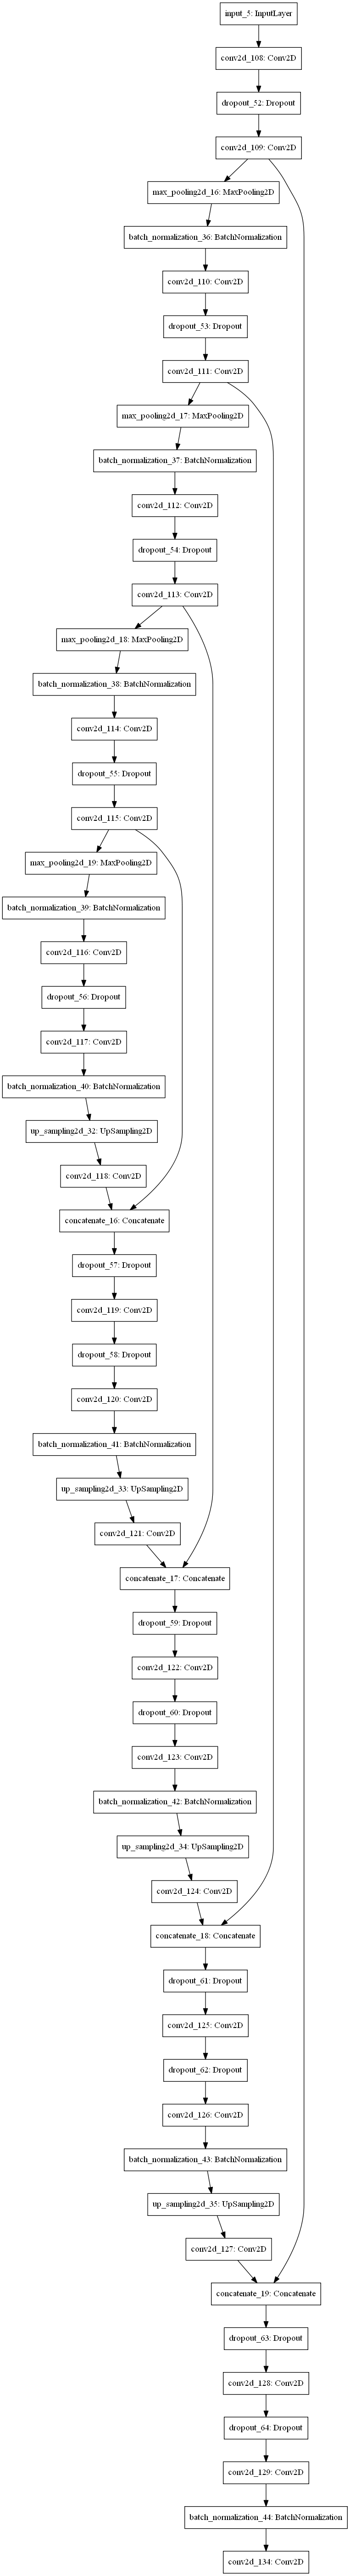

In [12]:
models = UNet()
plot_model(models[-1])

In [ ]:
def loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

    return binary_crossentropy(y_true, y_pred) + 5.0 * dice_loss(y_true, y_pred)

In [ ]:
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Compile
for i, m in enumerate(models):
    
    m.compile(optimizer=optimizer, loss=loss, metrics=[IoU])
    
    m.summary()

Model: "upsampled_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 32)     

# Training

In [ ]:
callbacks = []

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callback.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    callbacks.append(es_callback)

# Reduce learning rate on plateu
# --------------
reduce_lr = True
if(reduce_lr):
    es_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.00001, verbose=1)
    callbacks.append(es_callback )

In [ ]:
for m in models:
    m.fit(x=train_dataset,
          epochs=10,
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_img_gen), 
          callbacks=callbacks
          )

models[-1].save_weights("UNet_" + str(datetime.now().strftime('%b%d_%H-%M')) + ".h5")

Train for 192 steps, validate for 48 steps
Epoch 1/10
192/192 [==============================] - 49s 256ms/step - loss: 0.5732 - IoU: 0.1212 - val_loss: 0.4934 - val_IoU: 0.3915
Epoch 2/10
192/192 [==============================] - 47s 247ms/step - loss: 0.4447 - IoU: 0.4498 - val_loss: 0.4417 - val_IoU: 0.4338
Epoch 3/10
192/192 [==============================] - 47s 247ms/step - loss: 0.4014 - IoU: 0.5169 - val_loss: 0.3791 - val_IoU: 0.5299
Epoch 4/10
192/192 [==============================] - 47s 246ms/step - loss: 0.3799 - IoU: 0.5474 - val_loss: 0.3829 - val_IoU: 0.5075
Epoch 5/10
192/192 [==============================] - 48s 248ms/step - loss: 0.3614 - IoU: 0.5698 - val_loss: 0.3545 - val_IoU: 0.5862
Epoch 6/10
192/192 [==============================] - 47s 246ms/step - loss: 0.3478 - IoU: 0.5792 - val_loss: 0.3481 - val_IoU: 0.5809
Epoch 7/10
192/192 [==============================] - 47s 245ms/step - loss: 0.3406 - IoU: 0.5947 - val_loss: 0.3383 - val_IoU: 0.5803
Epoch 8/10
1

# Upload weights file to kaggle/colab instances



In [ ]:
from ipywidgets import FileUpload
upload = FileUpload()
upload

In [ ]:
for i, meta in enumerate(upload.metadata): 
    print(meta['name']) 
    with open(meta['name'], "w+b") as file_writer: 
        file_writer.write(upload.data[i])

Now you can load weigths: 

- model.load_weights
- model.load

and re-evaluate their scores.

In [ ]:
models[-1].evaluate(valid_dataset,
          steps=len(valid_img_gen))

models[-1].evaluate(train_dataset,
          steps=len(train_img_gen))

48/48 [==============================] - 8s 169ms/step - loss: 0.2753 - IoU: 0.6739


[0.27531634146968526, 0.6738562]

# Evaluate results

In [ ]:
# code snippet used to overlay the predictions and/or the target masks
# over the images to assess the performance of the model

def plotImageAndMask(img, mask=None, pred=None):
    red = (255, 0, 0)
    black = (0,0,0)
    white = (255,255,255)
    green = (0, 255,0)

    plt.figure(figsize=(15, 15))
    plt.imshow(img, 'gray', interpolation='none')
    if(mask is not None):
        transf_mask = np.where( mask == white , red , black )
        plt.imshow(transf_mask, interpolation='none', alpha=0.2)
    if(pred is not None):
        transf_pred = np.where( pred == white , green , black )
        plt.imshow(transf_pred, interpolation='none', alpha=0.2)
    plt.show()

# In red what has to be captured
# In green what is captured only by our model
# In orange what is captured by both

This procedure was used after training to compare the expected mask and the prediction
1. Fill the results object with the masks

In [ ]:
def prediction_to_mask(prediction):
    return tf.cast(prediction > 0.5, tf.float32)

image_filenames = next(os.walk(PATH+'/training/images/img'))[2]

results = {}
for image_name in image_filenames[:5]:

    img = image.load_img(os.path.join(PATH + '/training/images/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255. 
    
    # take the name of the file disregarding of the extension 
    name_without_ext = image_name[:-4]
    # obtain the prediction from the model
    prediction = models[-1].predict(img_tensor)[0]
   
    # transform into a mask
    results[name_without_ext] = prediction_to_mask(prediction)

2. Plot the results

In [ ]:
for image_name in results:
    # obtain the image from file
    img = image.load_img(os.path.join(PATH + '/training/images/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
    # obtain the mask from file
    mask1 = image.load_img(os.path.join(PATH + '/training/masks/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))

    pred = results[image_name]
    mask2 = grayscale_to_colour(pred)
    plotImageAndMask(img, image.img_to_array(mask1), mask2)

# Collect results 

In [ ]:
image_filenames = next(os.walk(PATH + '/test/images/img'))[2]

results = {}
for image_name in image_filenames[:]:

    img = image.load_img(os.path.join(PATH + '/test/images/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255. 
    
    # take the name of the file disregarding of the extension 
    name_without_ext = image_name[:-4]
    # obtain the prediction from the model
    prediction = models[-1].predict(img_tensor)[0]
    # transform into a mask and store into result object
    results[name_without_ext] = prediction_to_mask(prediction)

In [ ]:
# Optional visualization of the results
for image_name in results:
    img = image.load_img(os.path.join(PATH+'/test/images/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
    #mask1 = image.load_img(os.path.join(PATH+'/training/masks/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))

    pred = results[image_name]
    mask2 = grayscale_to_colour(pred)
    plotImageAndMask(img, pred=mask2)

# Producing the csv for submission

In [ ]:
def rle_encode(img):
    # Flatten column-wise
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(csv_fname, 'w') as f:

        f.write('ImageId,EncodedPixels,Width,Height\n')

        for key, value in results.items():
            f.write(key + ',' + str(rle_encode(np.array(value))) + ',' + '256' + ',' + '256' + '\n')

In [ ]:
create_csv(results)

# Transfer Learning 

As a first attempt, we used VGG16:

In [ ]:
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout, UpSampling2D

def unet_vgg():
    
    # Weights path (downloaded online)
    vgg_weight_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

    img_input = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 3))

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for_pretrained_weight = MaxPooling2D()(x)

    # Load pretrained weights.
    if vgg_weight_path is not None:
        vgg16 = tf.keras.models.Model(img_input, for_pretrained_weight)
        vgg16.load_weights(vgg_weight_path, by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # last conv
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = tf.keras.models.Model(img_input, x)
    
    return model

Then, since VGG16 was performing pretty bad (0.57 on test set), we skipped to another model. 

As said at the beginning of the notebook, for simplicity we used the [segmentation_models](https://github.com/qubvel/segmentation_models) library.

In [ ]:
!pip install segmentation_models

In [ ]:
import segmentation_models as sm

BACKBONE = 'efficientnetb0'
preprocess_input = sm.get_preprocessing(BACKBONE)

model = sm.Unet(BACKBONE, encoder_weights='imagenet')

In [ ]:
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[IoU, sm.metrics.iou_score],
)

In [ ]:
model.fit_generator(train_gen,
          epochs=20,
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_gen,
          validation_steps=len(valid_img_gen)
          )

Unfortunately, **it is not compatible with TF 2.0 yet**, thus it is necessary to change 2-3 things in the code in order to use it. 

I report here the last 20 epochs (total 60 epochs) of the training:

*Epoch 1/20<br>
431/431 - 121s 281ms/step - loss: 0.2519 - IoU: 0.8793 - iou_score: 0.8579 - val_loss: 0.5754 - val_IoU: 0.7641 - val_iou_score: 0.7509<br>
Epoch 2/20<br>
431/431 - 121s 280ms/step - loss: 0.1940 - IoU: 0.9063 - iou_score: 0.8898 - val_loss: 0.5559 - val_IoU: 0.7806 - val_iou_score: 0.7706<br>
Epoch 3/20<br>
431/431 - 121s 281ms/step - loss: 0.1758 - IoU: 0.9145 - iou_score: 0.8997 - val_loss: 0.5938 - val_IoU: 0.7688 - val_iou_score: 0.7596<br>
Epoch 4/20<br>
431/431 - 121s 281ms/step - loss: 0.1704 - IoU: 0.9167 - iou_score: 0.9023 - val_loss: 0.5768 - val_IoU: 0.7799 - val_iou_score: 0.7715<br>
Epoch 5/20<br>
431/431 - 120s 280ms/step - loss: 0.1582 - IoU: 0.9227 - iou_score: 0.9093 - val_loss: 0.5852 - val_IoU: 0.7829 - val_iou_score: 0.7755<br>
Epoch 6/20<br>
431/431 - 121s 280ms/step - loss: 0.1566 - IoU: 0.9235 - iou_score: 0.9103 - val_loss: 0.6215 - val_IoU: 0.7737 - val_iou_score: 0.7663<br>
Epoch 7/20<br>
431/431 - 121s 281ms/step - loss: 0.1562 - IoU: 0.9237 - iou_score: 0.9104 - val_loss: 0.5634 - val_IoU: 0.7857 - val_iou_score: 0.7772<br>
Epoch 8/20<br>
431/431 - 121s 281ms/step - loss: 0.1491 - IoU: 0.9270 - iou_score: 0.9144 - val_loss: 0.5917 - val_IoU: 0.7815 - val_iou_score: 0.7744<br>
Epoch 9/20<br>
431/431 - 121s 281ms/step - loss: 0.1530 - IoU: 0.9251 - iou_score: 0.9122 - val_loss: 0.5979 - val_IoU: 0.7769 - val_iou_score: 0.7690<br>
Epoch 10/20<br>
431/431 - 121s 281ms/step - loss: 0.1669 - IoU: 0.9186 - iou_score: 0.9045 - val_loss: 0.5927 - val_IoU: 0.7746 - val_iou_score: 0.7665<br>
Epoch 11/20<br>
431/431 - 121s 281ms/step - loss: 0.1702 - IoU: 0.9171 - iou_score: 0.9028 - val_loss: 0.5721 - val_IoU: 0.7791 - val_iou_score: 0.7705<br>
Epoch 12/20<br>
431/431 - 121s 281ms/step - loss: 0.1506 - IoU: 0.9262 - iou_score: 0.9134 - val_loss: 0.5810 - val_IoU: 0.7771 - val_iou_score: 0.7688<br>
Epoch 13/20<br>
431/431 - 121s 280ms/step - loss: 0.1486 - IoU: 0.9273 - iou_score: 0.9147 - val_loss: 0.6200 - val_IoU: 0.7705 - val_iou_score: 0.7630<br>
Epoch 14/20<br>
431/431 - 120s 279ms/step - loss: 0.1459 - IoU: 0.9285 - iou_score: 0.9161 - val_loss: 0.6076 - val_IoU: 0.7762 - val_iou_score: 0.7694<br>
Epoch 15/20<br>
431/431 - 120s 279ms/step - loss: 0.1471 - IoU: 0.9281 - iou_score: 0.9157 - val_loss: 0.6306 - val_IoU: 0.7578 - val_iou_score: 0.7476<br>
Epoch 16/20<br>
431/431 - 120s 277ms/step - loss: 0.1568 - IoU: 0.9233 - iou_score: 0.9101 - val_loss: 0.5909 - val_IoU: 0.7773 - val_iou_score: 0.7696<br>
Epoch 17/20<br>
431/431 - 119s 277ms/step - loss: 0.1657 - IoU: 0.9200 - iou_score: 0.9062 - val_loss: 0.8368 - val_IoU: 0.6990 - val_iou_score: 0.6888<br>
Epoch 18/20<br>
431/431 - 120s 279ms/step - loss: 0.1893 - IoU: 0.9083 - iou_score: 0.8921 - val_loss: 0.6012 - val_IoU: 0.7773 - val_iou_score: 0.7696<br>
Epoch 19/20<br>
431/431 - 121s 282ms/step - loss: 0.1478 - IoU: 0.9275 - iou_score: 0.9149 - val_loss: 0.5829 - val_IoU: 0.7789 - val_iou_score: 0.7711<br>
Epoch 20/20<br>
431/431 - 121s 281ms/step - loss: 0.1358 - IoU: 0.9336 - iou_score: 0.9220 - val_loss: 0.6204 - val_IoU: 0.7797 - val_iou_score: 0.7738*

# Interesting things that could have worked

### Training and model

*   Successive optimization of each upsampling layer.
Following [Fully Convolutional Networks for Semantic Segmentation](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf) we built several overlapping models. In this case we considered U-Net and, starting from the bottleneck layer, every time a block in which was present an upsampling layer was introduced, we did the following:

    1. take the output of such a layer 
    2. properly increase the spatial extent exploiting an upsampling layer without parameters (nearest) directly to output resolution (256x256) 
    3. add 1x1 convolution 
    4. add a sigmoid activation.

We train the models starting from the block that requires the highest upsampling factor, ending with the lowest. 
Optimizing with 10-30 epochs at each layer we noticed a 2% increment of IoU on the test set (0.48743 to 0.50867).

In [ ]:
'''
exploiting the following functions
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    
def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
'''

def UNet():
    # Instead of a single model return an array of them
    # All of them share the convolution part of the network and part of the upsampling
    
    models = []
    
    f = [16,32,64,128]
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))
    p0 = inputs
    
    downsampling_layers  = [p0]
    convolutional_layers = []
    # create a downsampling part of the network
    # and save the convolutions to enable creation of skip connection
    for i, n_filt in enumerate(f[1:-1]):
        cx, px = down_block(downsampling_layers[i], n_filt) # spatial extent 2A x 2A -> A x A
        downsampling_layers.append(px)
        convolutional_layers.append(cx)
    
    bn = bottleneck(downsampling_layers[-1], f[-1])
    
    # create the upsampling part of the network
    upsampling_layers = [bn]
    for i, n_filt in enumerate(reversed(f[1:-1]) ):
        ux = up_block(upsampling_layers[i], convolutional_layers[- i -1], n_filt ) # spatial extent A x A -> 2A x 2A
        upsampling_layers.append(ux)

    
    # for each upsampling layer create a model that can be trained with the same couple of full resolution 
    # image/mask as the whole nn.
    # In order to do so we have to upsample accordingly
    for i in range(len(upsampling_layers)-1):
        # up sample 
        upsampling_factor = 2 ** ( len(upsampling_layers) - i -1)
        upx     = tf.keras.layers.UpSampling2D((upsampling_factor, upsampling_factor))(upsampling_layers[i])
        outputx = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(upx)
        nn_name = 'upsampled_'+str(upsampling_factor)
        models.append(tf.keras.models.Model(inputs, outputx, name=nn_name))

    # create the final model
    output = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(upsampling_layers[-1])
    models.append( tf.keras.models.Model(inputs, output, name = "true_model"))
    
    return models

* [Follows from the previous comment...] One could argue that each time we stop to optimize a model and we move to the following one we are throwing a number of layers(proper upsampling, 1x1 convolution, 1 sigmoid). We have tried to recombine those information in a new model.

In [ ]:
def UNet():
    # Modifications required to perform such a task 
    [...]
    
    outputs = []
    for m in models:
        outputs.append(m.output)
    
    conc = tf.keras.layers.Concatenate()(outputs)
    outputx = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(conc)
    models.append( tf.keras.models.Model(inputs, outputx, name = "true_true_model"))

    return models

#### Dense U-Net

Based on [Dense U-net based on patch-based learning for Retinal Vessel Segmentation](https://www.mdpi.com/1099-4300/21/2/168)

* Add residual link to the downsampling/upsampling blocks
![](https://www.mdpi.com/entropy/entropy-21-00168/article_deploy/html/images/entropy-21-00168-g003a-550.jpg)
* Foster the reutilization of results produced in the bottleneck.
![](https://www.mdpi.com/entropy/entropy-21-00168/article_deploy/html/images/entropy-21-00168-g003b-550.jpg)

Here follows the reformulation of down sampling/up sampling blocks/ bottleneck blocks to obtain DenseUNet

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(x)
    n = tf.keras.layers.BatchNormalization()(c)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(n)
    n = tf.keras.layers.BatchNormalization()(c)
    residual = tf.keras.layers.Add()([n, x])
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(residual)
    return residual, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    #us = tf.keras.layers.UpSampling2D((2, 2))(x)
    us =  tf.keras.layers.Conv2DTranspose(filters ,(2, 2), strides=(2,2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    d = tf.keras.layers.SpatialDropout2D(0.2)(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(d)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(c)
    c = tf.keras.layers.Add()([us, c])
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c1 = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(x)
    c2 = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(c1)
    conc2 = tf.keras.layers.Concatenate()([c1,c2])
    c3 = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(conc2)
    conc3 = tf.keras.layers.Concatenate()([c1,c2,c3])
    c4 = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(conc3)
    conc4 = tf.keras.layers.Concatenate()([c1,c2,c3,c4])
    c5 = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(conc4)
    return c5

#### ResUNet

From the paper --> [Road Extraction by Deep Residual U-Net](https://arxiv.org/pdf/1711.10684.pdf)

![resunet](https://i.ibb.co/dWrbFNh/resunet.png)

In [ ]:
def bn_act(x, act=True):
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tf.keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tf.keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = tf.keras.layers.UpSampling2D((2, 2))(x)
    c = tf.keras.layers.Concatenate()([u, xskip])
    return c

# ------------------------------------------------------------------------

def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

### Preprocessing

As already written at the beginning of the notebook:

1. [Consider only the red channel](https://pdfs.semanticscholar.org/4d37/ddb41c799e67ed2d2a5f16fe2156dbec8959.pdf) (~.66 IoU)
2. Run Histogram Equalization / Local Equalization on input images (negligible improvement)
3. Give in input grayscale images (worse results)
4. Supply as an input an extra information, w.r.t. the plain image, coming from well known algorithms known in the context of Image Processing, such as the Sobel filter.

In order to mantain the freedom of applying whatever python function we want as a preprocessing function, we created an ad-hoc generator to feed the input pipeline:

In [ ]:
def loader(basepath=''):
    def loadFromFile(path):
        #print(basepath, path)
        if basepath is not '':
            path = basepath.decode("utf-8")  + '/'+ path.decode("utf-8") 
            
        img = Image.open(path)
        return np.array(img)
    return loadFromFile

class myDataset(tf.data.Dataset):
   
    def __new__(self, basepath, output_shapes, output_types, validation_split=0.0, seed=None, subset='training', funct = None ):
        self.basepath = basepath
        
        if(seed is not None):
            tf.random.set_seed(SEED)
            np.random.seed(SEED)
      
        #print(os.listdir(basepath))
        files = [f for f in os.listdir(basepath) if os.path.isfile(basepath + "/" + f)]
        files = np.array(files)   
        np.random.shuffle(files)

        split_indx = round( validation_split * len(files) )

        if subset == 'validation':
            self.subset = files[:split_indx]
            self.number_of_items = split_indx
            
        else :
            self.subset = files[split_indx:]
            self.number_of_items =len(files)- split_indx
            
        print( self.number_of_items, 'files found')
        
        def producer_generator(funct):
            def generator(basepath,subset):
                
                loadFromFile = loader(basepath)
                res = map(loadFromFile,subset)

                if funct is not None:
                    print('executed:',funct)
                    res = map(funct, res)

                res = map(tf.convert_to_tensor, res)

                for el in iter(res):
                    yield el
                
            return generator
        
        generator = producer_generator(funct)
        
        return self.number_of_items, tf.data.Dataset.from_generator(
            generator,
            output_types=output_types,
            output_shapes=output_shapes,
            args = (self.basepath, self.subset)
        )
    
    def number_of_items(self):
        return self.number_of_items

In [ ]:
def prepare_img(x):
    x = tf.cast(tf.cast(x, tf.int32), tf.float32)*1.0/255
    return x

def prepare_mask(x):
    x = tf.cast(tf.cast(x, tf.int32), tf.float32)*1.0/255
    return np.expand_dims(x, axis=-1)

In [ ]:
training_steps,dataset_img = myDataset(PATH + '/training/images/img', 
                         output_shapes=[IMG_HEIGHT, IMG_WIDTH, 3],
                         output_types=tf.float32,
                         funct=prepare_img, 
                         validation_split=0.1, 
                         seed= SEED)

_, dataset_masks = myDataset(PATH + '/training/masks/img',
                        output_shapes=[IMG_HEIGHT, IMG_WIDTH, 1],
                        output_types=tf.float32,
                        funct=prepare_mask,
                        validation_split=0.1, 
                        seed= SEED)

train_dataset = tf.data.Dataset.zip((dataset_img,dataset_masks)).batch( batch_size,drop_remainder=True )
train_dataset_cached = train_dataset.cache()



validation_steps,dataset_valid_img = myDataset(PATH + '/training/images/img', 
                        [IMG_HEIGHT, IMG_WIDTH, 3],
                        tf.float32,
                        funct=prepare_img, 
                        validation_split=0.1,
                        subset = 'validation',
                        seed= SEED)

_,dataset_valid_masks = myDataset(PATH + '/training/masks/img',
                        output_shapes=[IMG_HEIGHT, IMG_WIDTH, 1],
                        output_types=tf.float32,
                        funct=prepare_mask,
                        validation_split=0.1,
                        subset = 'validation',
                        seed= SEED)


valid_dataset = tf.data.Dataset.zip((dataset_valid_img,dataset_valid_masks)).batch( batch_size,drop_remainder=True )
valid_dataset_cached = valid_dataset.cache()

There are several ways in which 
`prepare_img()`
can be written and this encapsulates the particular preprocessing function we want to accomplish.

1. convert into PIL Image object and apply some filtering to cancel some noise in the image:
```
img = Image.fromarray(x.astype('uint8'), 'RGB')
#one of the following
img = img.filter(ImageFilter.MedianFilter(size=3))
img = img.filter(ImageFilter.GaussianBlur(radius=2))
img = img.filter(ImageFilter.MinFilter(size=5))
img = img.filter(ImageFilter.EDGE_ENHANCE)
img = ImageEnhance.Color(img).enhance(2.0)
return img
```
2.Enhance the contrast in the image by performing global or local histogram equalization
```
img  = ImageOps.equalize(img, mask = None) 
return img
```
or 
```
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img =clahe.apply(x)
return img
```
3. Extract a sort of feature from the input image and provide it as an additional input for the model, in the form of an extra channel
[ ImageFilter.FIND_EDGES == DIGITAL LAPLACIAN FILTER](https://pythontic.com/image-processing/pillow/edge-detection)
```
y = img.filter(ImageFilter.FIND_EDGES)  
y = np.array(y)
y = y[:,:,0]+y[:,:,1]+y[:,:,2]
y = np.where( y > 255 , 255, y ) 
y = np.expand_dims(y, axis=-1)
# in such a case to produce the output we concatenated to the image the extra channel
x1 = tf.cast(tf.cast(x, tf.int32), tf.float32)*1.0/255
y1 = tf.cast(tf.cast(y, tf.int32), tf.float32)*1.0/255
return np.concatenate((x1,y1), axis=-1) 
```



4. Enrich the input dataset by creating syntetic aerial Images by extracting buildings from the original dataset and pasting them in random positions of the input images (unfeasible due to a too long training).

In [ ]:
# Function that loads an image given its name and the basepath in which to search
def loader(basepath=''):
    def loadFromFile(path):
        #print(basepath, path)
        if basepath is not '':
            path = basepath.decode("utf-8")  + '/'+ path.decode("utf-8") 
            
        img = Image.open(path)
        return np.array(img)
    return loadFromFile

# Function that extracts building randomly from the image supplied as an argument.
def get_random_building(img,mask):
    lbl, nlbl = ndimage.label(mask[:,:,0])
  
    assert(nlbl != 0)
    if nlbl == 1:
        chosen_building_lbl = 1
    else:
        chosen_building_lbl = np.random.randint(1,nlbl)
    #take a random label
    print(nlbl, 'buildings found; ', chosen_building_lbl, ' chosen')
    pos        = np.argwhere(lbl==chosen_building_lbl)
    # create the base image and mask
    mask_n     = np.zeros(img.shape) 
    building   = np.zeros(img.shape)
    # fill the image and the mask
    for p in pos:
        building[p[0],p[1]] = img[p[0],p[1]]
        mask_n[p[0],p[1]] = 1
    return building,mask_n

# Function used to collect a finite amount of buildings for later usage
def extract_buildings(imgs_and_masks, nr=100):
    rand_buildings = []
    it = iter(imgs_and_masks)

    for i in range(nr):
        img,mask = next(it)
        new_img, new_build = get_random_building(img,mask)
        rand_buildings.append(( new_img, new_build))
    return rand_buildings

# Function that superimposes non-zero RGB pixels of image2/mask2 on top of image1/mask1.
# shx, shy are the number of pixels for which image2/mask2 is translated before superimposition. 
def overlay(img1, mask1, img2, mask2, shx=0, shy=0):
  
    pos = np.argwhere(mask2==1)
  
    for p in pos:
      
        if p[0]+shx < 0:
            continue
        if p[0]+shx > img1.shape[0]:
            continue
        if p[1]+shx < 0:
            continue
        if p[1]+shy > img1.shape[1]:
            continue
      
        img1[int(p[0]+shx),int(p[1]+shy)] = img2[p[0],p[1]]
        mask1[int(p[0]+shx),int(p[1]+shy),0] = 255

    return img1,mask1/255

# A class that generates syntetic couples of images/masks.
# This is a refinement of the previous class considered the fact that 
# we have to hold both image/mask to perform overlaying of a random building 
class mySyntheticDataset:
    def __new__(self, basepath1, basepath2, output_shapes, output_types,
                validation_split=0.0, seed=None, subset='training', 
                funct1 = None, funct2=None, functboth=None ):
        self.basepath1 = basepath1
        self.basepath2 = basepath2
        
        self.funct1 = funct1
        self.funct2 = funct2
        self.functboth = functboth
        self.output_types = output_types
        self.output_shapes = output_shapes
        
        if(seed is not None):
            tf.random.set_seed(SEED)
            np.random.seed(SEED)
      
        # Take files from one of the two directory consider thateach file in basepath1 
        # are matched with a file with the same name under basepath2
        files = [f for f in os.listdir(basepath1) if os.path.isfile(basepath1 + "/" + f)]
        files = np.array(files)   
        np.random.shuffle(files)

        split_indx = round( validation_split * len(files) )

        if subset == 'validation':
            self.subset = files[:split_indx]
            self.number_of_items = split_indx
            
        else :
            self.subset = files[split_indx:]
            self.number_of_items =len(files)- split_indx
            
        print(self.number_of_items, 'files found')
        return self
    
    def number_of_items(self):
        return self.number_of_items
    
    def obtain_dataset(self):
        
        def producer_generator(funct1, funct2, functboth):
            def generator(basepath1, basepath2, subset):
                # Since has been used for testing purposes
                # this class is less general 

                # load images
                loadFromFile = loader(basepath1)
                images = map(loadFromFile,subset)
                # load masks
                loadFromFile = loader(basepath2)
                masks = map(loadFromFile,subset)
                # execute preprocessing functions
                # separately for images and masks
                if funct1 is not None:
                    print('executed:',funct1)
                    images = map(funct1, images)
                    
                if funct2 is not None:
                    print('executed:',funct2)
                    masks = map(funct2, masks)
                # arrange images and masks in couples
                res = zip(images, masks)
                # extract randomly 5 buildings
                buildings = extract_buildings(res,5)
                # yield couples images/masks after randomly superimposing
                # a building.
                while True:
                    for img1,mask1 in iter(res):

                        img2, mask2 = buildings[np.random.randint(len(buildings))]
                      
                        shx, shy = (np.random.random(2)-0.5)*255;

                        yield overlay(img1,mask1,img2,mask2, shx, shy )
                
            return generator
        
        generator = producer_generator(self.funct1, self.funct2, self.functboth)
        
        return self.number_of_items, tf.data.Dataset.from_generator(
            generator,
            output_types =self.output_types,
            output_shapes=self.output_shapes,
            args = (self.basepath1, self.basepath2, self.subset)
        )
    
def prepare_img(x):
    x = x * 1.0/255.
    return x

def prepare_mask(x):
    x = tf.cast(x, tf.float32)*1.0/255.0
    return tf.expand_dims(x, axis=-1)

my_generator_train = mySyntheticDataset(PATH + '/training/images/img', 
                        PATH + '/training/masks/img',
                        output_shapes=([None, None, CH_INPUT], [None, None, 1]),
                        output_types=(tf.float32, tf.float32) ,
                        funct1=prepare_img, 
                        funct2 = lambda x: np.expand_dims(x,-1),
                        
                        validation_split=0.15, 
                        subset = 'training',
                        seed= SEED)

nr, train_dataset = my_generator_train.obtain_dataset(my_generator_train)

train_dataset = train_dataset.batch( batch_size,drop_remainder=True )

Example of building detection and extraction:




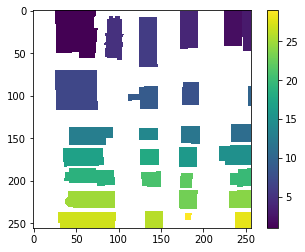

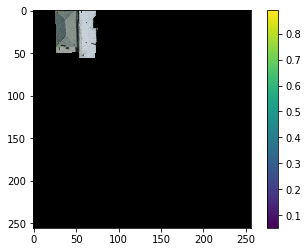


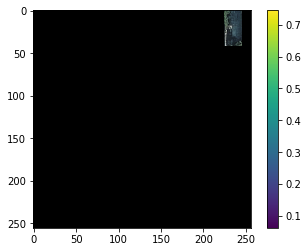

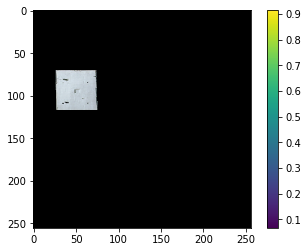

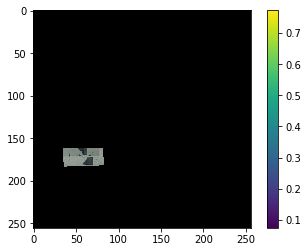



















**Original image:**

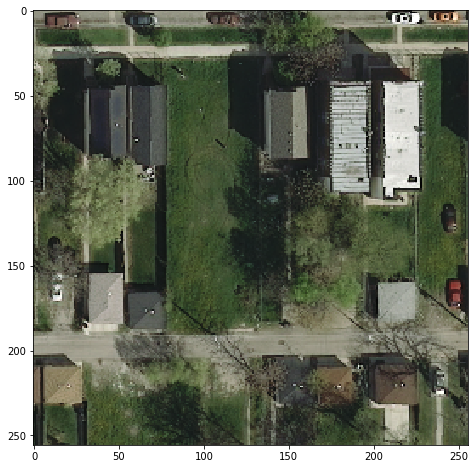

**Augmented:**

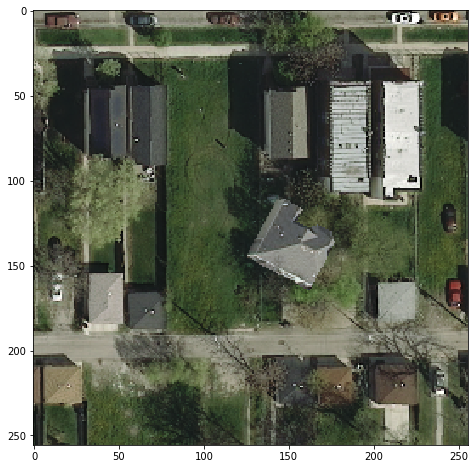

Follows an example of training using 10 batches (each made of 32) only for training and 1 for validation takes almost as 1 epoch without creating syntetic views.
Here we can note how long it takes to generate that dataset.
The messages that are printed are mainly for debugging purposes, and give some insights on how buildings are extracted.


```
training: upsampled_8
Train for 10 steps, validate for 1 steps
Epoch 1/30
executed: <function prepare_img at 0x7f1bd60bcc80>
executed: <function <lambda> at 0x7f1bd9895488>
29 buildings found;  25  chosen
9 buildings found;  2  chosen
10 buildings found;  6  chosen
2 buildings found;  1  chosen
5 buildings found;  4  chosen
executed: <function prepare_img at 0x7f1bd60bcc80>
executed: <function <lambda> at 0x7f1bdad9bbf8>
3 buildings found;  1  chosen
14 buildings found;  1  chosen
4 buildings found;  1  chosen
3 buildings found;  2  chosen
14 buildings found;  10  chosen
10/10 [==============================] - 51s 5s/step - loss: 30.0775 - IoU: 0.1313 - val_loss: 6.1686 - val_IoU: 0.2106
[...]
Epoch 7/30
 9/10 [==========================>...] - ETA: 5s - loss: 1.0129 - IoU: 0.2894 
executed: <function prepare_img at 0x7f1bd60bcc80>
executed: <function <lambda> at 0x7f1bdad9bbf8>
3 buildings found;  1  chosen
14 buildings found;  9  chosen
4 buildings found;  3  chosen
3 buildings found;  2  chosen
14 buildings found;  13  chosen
10/10 [==============================] - 55s 6s/step - loss: 1.0177 - IoU: 0.2865 - val_loss: 1.6465 - val_IoU: 0.2369
```



### Postprocessing
1. Performing Opening/Closing operation on the output.
 A comparison with a UNet architecture:  


> 1.   Closing.....: 0.59059
> 2.   Opening..: 0.59035
> 3.   Plain..........: 0.59043


2. Set an higher threshold to distinguish between  buildings and non-buildings

 

### Considering a different cost function:
  1. Rebalance error to account for class imbalance in images. (negligible improvement)


In [ ]:
# 0's are more frequent in the output than 1's.
# In order to take into account that unbalance we tried to reweight the loss function.

# Collect weights
ite = iter(train_dataset)
weights = [0,0]
for i in range(len(train_img_gen)):
    batch = next(ite)
    for s in batch:
        img = s[0]
        mask = s[1]
        weights[0] += np.where(mask == 0)[0].shape[0]
        weights[1] += np.where(mask == 1)[0].shape[0]
        
# weights
print(weights)
tot = weights[0]+weights[1]

weights[0] = tot/weights[0]
weights[1] = tot/weights[1]

for m in models:
    m.fit(x=train_dataset,
          epochs=10,
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_img_gen), 
          callbacks=callbacks
          ,class_weight = weights)

models[-1].save_weights("UNet_" + str(datetime.now().strftime('%b%d_%H-%M')) + ".h5")


>   2. Weight more errors in the nearby of the buildings to foster the optimizer towards better contours (negligible improvement)
  3. Weight more small buildings to prevent the optimizer to ignore them. (no improvement)
 
 

1. Identify buildings

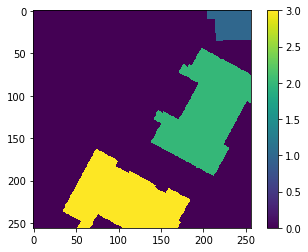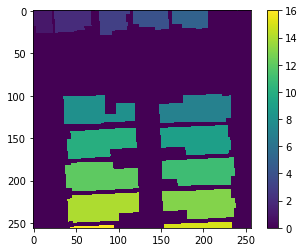

2. Weighting buildings based on area 


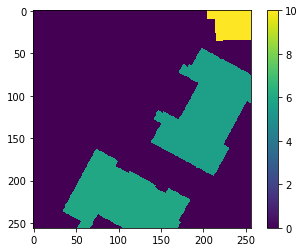
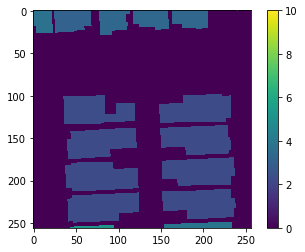

Weight Pixel based on distance from the nearest building

1. distance in pixels


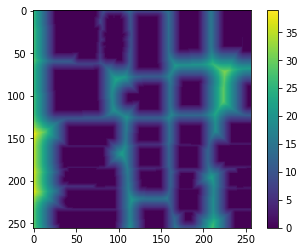

2. Weights

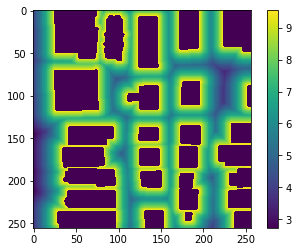

Since those weights have to be specific for each considered image and to avoid to recompute every time during training all the weights, an additional channel is added to each target mask and then separated when computing the loss or the metric.

It can be easily integrated with custom dataset generator.

In [ ]:
def prepare_mask(x):
    
    # Exploit the last channel of the image to carry a weighting coefficient
    # In order to avoid setting a too high penalty on specific pixels we let those 
    # weight coefficient to take values between 1 and 10

    # 1. Due to distance
    # numpy:
    # Although not completely clear from documentatiotn but distance_transform_edt 
    # computes the distance from non-zero (i.e. non-background) points to
    # the nearest zero (i.e. background) point.
    weight_distance = ndimage.distance_transform_edt(x == 0)
    
    weight_distance = np.where(weight_distance <= 0, weight_distance.max(),weight_distance)
    weight_distance =10*np.exp(-weight_distance/30)
    #2. weight due to area
    lbl, nlbl = ndimage.label(x)
    def fn(val, pos):
        
        return val.sum()

    area = ndimage.labeled_comprehension(x, lbl, range(1,nlbl+1), fn, float, 0, True)

    weigth_area = np.where( lbl == 0 , 0 , np.log(area.max()/area[lbl-1] )+1)
    weigth_area = weigth_area*10/weigth_area.max()

    weights = tf.cast( weigth_area + weight_distance +1 ,tf.float32) 
    #weights = tf.cast( weight_distance +1,tf.float32) 
    x = tf.cast(x, tf.float32)/255.0

    return np.concatenate( [tf.expand_dims(x, axis=-1), np.expand_dims(weights, axis=-1)], axis=-1)

The loss/IoU functions were rewritten to take into account the fact that the target dataset has two components.

In [ ]:
def loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

    # Divide the real y_true and the weight mask
    y_true , area_w = tf.split(y_true,[1,1], axis=-1)
    w = tf.cast(area_w[:,:,:,:], tf.float32)

    return w*tf.keras.losses.binary_crossentropy(y_true, y_pred) + 5.*dice_loss(y_true, y_pred)
     
def IoU(y_true, y_pred):
    #Divide the real y_true and the weight mask
    y_true , area_w = tf.split(y_true,[1,1], axis=-1)
    # from probability to predicted class {0, 1}
    y_pred = tf.cast(y_pred > 0.5, tf.float32) # when using sigmoid. Use argmax for softmax
    # A and B
    intersection = tf.reduce_sum(y_true * y_pred)
    # A or B
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    # IoU
    return intersection / union

#### Polygonization

We eventually tried to create and smooth polygons from pixel, with the idea of removing some noise in the predictions (small irregular buildings) and of making smoother the borders of the buildings.

In [ ]:
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict

def mask_for_polygons(polygons):
    img_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

def mask_to_polygons(mask, epsilon=5., min_area=10.):
    # first, find contours with cv2
    mask = cv2.cvtColor(np.uint8(mask), cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(
        ((mask == 255) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]

    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

The following is an extreme version, where the lines are too straight, but it is just to give an idea of the result.

![polygons](https://i.ibb.co/vPj0bbc/polygons.png)

Nevertheless, also using less straight lines, the obtained score was more or less the same.